<a href="https://colab.research.google.com/github/Cryslender/AI-Exam-machine-learning-/blob/main/AI_Exam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Necessary Modules

In [6]:
!pip install keras-tuner -q
import keras_tuner
import tensorflow as tf
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import numpy as np
from tabulate import tabulate
from keras.utils.vis_utils import plot_model
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import layers
%matplotlib inline
np.random.seed(0)

#Dataset

In [7]:
#importing MNIST dataset from keras to use it in the program
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print("Training Dataset")
print("X_Training: ", str(x_train.shape))
print("Y_Training: ", str(y_train.shape))
print("\nTesting Dataset")
print("X_Testing: ", str(x_test.shape))
print("Y_Testing: ", str(y_test.shape))

Training Dataset
X_Training:  (60000, 28, 28)
Y_Training:  (60000,)

Testing Dataset
X_Testing:  (10000, 28, 28)
Y_Testing:  (10000,)


#Data Pre-processing

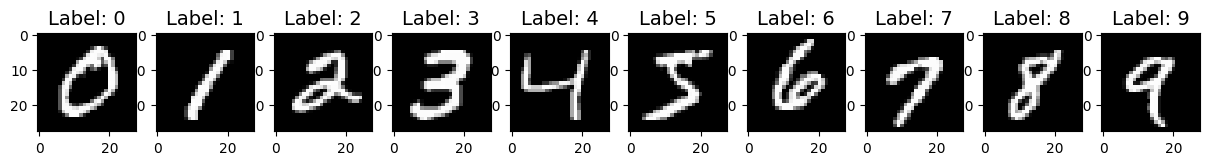

In [8]:
#ploting the dataset
fig,axes = plt.subplots(1, 10, figsize=(15,15))

for i in range(0, 10):
  axes[i].imshow(x_train[y_train == i][0], cmap=plt.get_cmap('gray'))
  axes[i].set_title("Label: {}".format(i), fontsize=14)

In [10]:
# Count the occurrences of each digit in the training set
train_digit_count = np.bincount(y_train)

# Count the occurrences of each digit in the testing set
test_digit_count = np.bincount(y_test)

# Calculate the subtotal by adding the counts from the training and testing sets
subtotal_digit_count = train_digit_count + test_digit_count

# Calculate the total counts by summing the subtotal counts
total_digit_count = np.sum(subtotal_digit_count)

# Generate x-axis labels for each digit
digits = np.arange(10)

# Create a table
table = []
for digit, train_count, test_count, subtotal_count in zip(
    digits, train_digit_count, test_digit_count, subtotal_digit_count):
    table.append([digit, train_count, test_count, subtotal_count])

# Append a row for the subtotal
table.append(["Subtotal", np.sum(train_digit_count), np.sum(test_digit_count), np.sum(subtotal_digit_count)])

# Append a row for the total
table.append(["Total", "", "", total_digit_count])

# Define the table headers
headers = ["Digit", "Training Data", "Testing Data", "Subtotal"]

# Print the table
print(tabulate(table, headers, tablefmt="fancy_grid"))

╒══════════╤═════════════════╤════════════════╤════════════╕
│ Digit    │ Training Data   │ Testing Data   │   Subtotal │
╞══════════╪═════════════════╪════════════════╪════════════╡
│ 0        │ 5923            │ 980            │       6903 │
├──────────┼─────────────────┼────────────────┼────────────┤
│ 1        │ 6742            │ 1135           │       7877 │
├──────────┼─────────────────┼────────────────┼────────────┤
│ 2        │ 5958            │ 1032           │       6990 │
├──────────┼─────────────────┼────────────────┼────────────┤
│ 3        │ 6131            │ 1010           │       7141 │
├──────────┼─────────────────┼────────────────┼────────────┤
│ 4        │ 5842            │ 982            │       6824 │
├──────────┼─────────────────┼────────────────┼────────────┤
│ 5        │ 5421            │ 892            │       6313 │
├──────────┼─────────────────┼────────────────┼────────────┤
│ 6        │ 5918            │ 958            │       6876 │
├──────────┼────────────

In [90]:
# Normalize Data
x_train = x_train / 255.0
x_test = x_test / 255.0
# Reshape Data
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)
print(x_train.shape)

(60000, 784)


In [91]:
#convert the lables into one-hot enconded vector
num_classes=10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

for i in range(10):
  print(y_train[i])

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


#Model Design(ANN Model Structure)

In [96]:
#define model to build using dense layers for flatten array of images
def define_model(units, activation, dropout, lr):
    model = keras.Sequential()
    model.add(layers.Flatten())
    model.add(layers.Dense(units=units, activation=activation))
    if dropout:
        model.add(layers.Dropout(rate=0.25))
    model.add(layers.Dense(10, activation="softmax"))
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

#Create hyperparameters for the model to use tuner search on
def build_model(hp):
    units = hp.Int("units", min_value=32, max_value=512, step=32)
    activation = hp.Choice("activation", ["relu", "tanh","softmax","sigmoid","linear"])
    dropout = hp.Boolean("dropout")
    lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    # call existing model-building code with the hyperparameter values.
    model = define_model(
        units=units, activation=activation, dropout=dropout, lr=lr
    )
    return model

#Model training and validation

In [97]:
#define tuner class search called Random Search to search randomlly for perfect paramaeters on maximun trial of 3 since the dataset is big
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,
    directory="my_document",
    project_name="AI Exam",
)
tuner.search_space_summary()
tuner.search(x_train, y_train, epochs=2, validation_data=(x_train, y_train))

Trial 3 Complete [00h 01m 24s]
val_accuracy: 0.9139416813850403

Best val_accuracy So Far: 0.9467083513736725
Total elapsed time: 00h 04m 08s


In [98]:
tuner.results_summary()

Results summary
Results in my_document/AI Exam
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 1 summary
Hyperparameters:
units: 288
activation: sigmoid
dropout: False
lr: 0.0005761315077006069
Score: 0.9467083513736725

Trial 2 summary
Hyperparameters:
units: 192
activation: linear
dropout: False
lr: 0.0020187460474604367
Score: 0.9139416813850403

Trial 0 summary
Hyperparameters:
units: 512
activation: softmax
dropout: False
lr: 0.00011840716382574924
Score: 0.6506833136081696


In [99]:
# Get the top 2 hyperparameters.
best_hps = tuner.get_best_hyperparameters(5)
# Build the model with the best hp.
model = build_model(best_hps[0])
# Fit with the entire dataset.
x_all = np.concatenate((x_train, x_test))
y_all = np.concatenate((y_train, y_test))
model.fit(x=x_all, y=y_all, epochs=2)

Epoch 1/2
2188/2188 [==============================] - 10s 5ms/step - loss: 0.3922 - accuracy: 0.8964
Epoch 2/2
2188/2188 [==============================] - 10s 4ms/step - loss: 0.2046 - accuracy: 0.9414


In [ ]:
# Generate a visualization of the model
plot_model(model, to_file='ann_structure.png', show_shapes=True, show_layer_names=True)

#Model evaluation and testing

In [101]:
#test the model on test data
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test Loss: {}, Test Accuracy: {}".format(test_loss, test_acc))

313/313 [==============================] - 1s 3ms/step - loss: 0.1525 - accuracy: 0.9553
Test Loss: 0.15245452523231506, Test Accuracy: 0.955299973487854


313/313 [==============================] - 1s 2ms/step


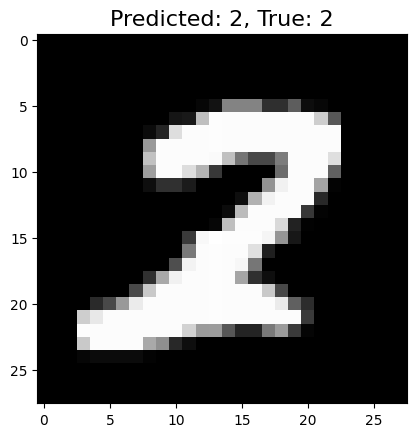

In [106]:
# check if the model predict the exert value
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
random_idx = np.random.choice(len(x_test))
x_sample = x_test[random_idx]
y_true = np.argmax(y_test, axis=1)
y_sample_true = y_true[random_idx]
y_sample_pred_class = y_pred_classes[random_idx]

plt.title("Predicted: {}, True: {}".format(y_sample_pred_class, y_sample_true), fontsize=16)
plt.imshow(x_sample.reshape(28, 28), cmap='gray')

#Confusion Matrix

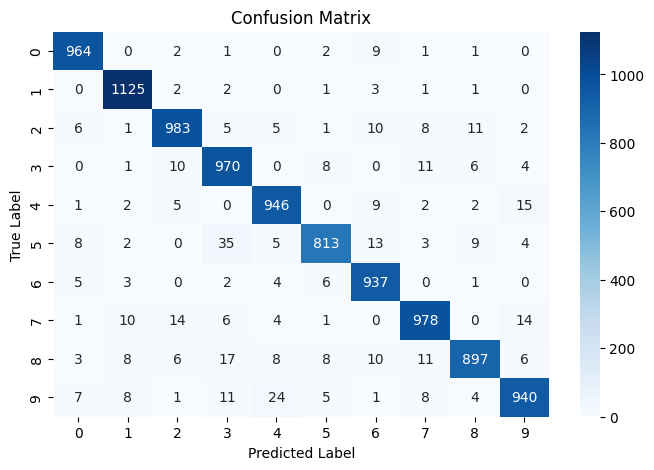

In [107]:
#display all the predicted imagies class and the error that model did during testing
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Plot
fig, ax = plt.subplots(figsize=(8,5))
ax = sns.heatmap(confusion_mtx, annot=True, fmt='d', ax=ax, cmap="Blues")
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix');